In [33]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.fftpack as sf
import scipy.constants as sc
# 参数设置
R_eta_c = 20e+3  # 景中心斜距
Tr = 2.5e-6  # 发射脉冲时宽
Kr = 20e+12  # 距离向调频率
alpha_os_r = 1.2  # 距离过采样率
Nrg = 320  # 距离线采样点数

# 距离向参数
Bw = abs(Kr) * Tr  # 距离信号带宽
Fr = alpha_os_r * Bw  # 距离向采样率
Nr = round(Fr * Tr)  # 距离采样点数(脉冲序列长度)

# 方位向参数
c = 3e+8  # 电磁传播速度
Vr = 150  # 等效雷达速度
Vs = Vr  # 卫星平台速度
Vg = Vr  # 波束扫描速度
f0 = 5.3e+9  # 雷达工作频率
Delta_f_dop = 80  # 多普勒带宽
alpha_os_a = 1.25  # 方位过采样率
Naz = 256  # 距离线数
theta_r_c = +3.5 * np.pi / 180  # 波束斜视角

# 方位向参数
lambda_r = c / f0  # 雷达工作波长
t_eta_c = -R_eta_c * np.sin(theta_r_c) / Vr  # 波束中心穿越时刻
f_eta_c = 2 * Vr * np.sin(theta_r_c) / lambda_r  # 多普勒中心频率
La = 0.886 * 2 * Vs * np.cos(theta_r_c) / Delta_f_dop  # 实际天线长度
Fa = alpha_os_a * Delta_f_dop  # 方位向采样率
Ta = 0.886 * lambda_r * R_eta_c / (La * Vg * np.cos(theta_r_c))  # 目标照射时间
R0 = R_eta_c * np.cos(theta_r_c)  # 最短斜距
Ka = 2 * Vr**2 * np.cos(theta_r_c)**2 / lambda_r / R0  # 方位向调频率
theta_bw = 0.886 * lambda_r / La  # 方位向3dB波束宽度
theta_syn = Vs / Vg * theta_bw  # 合成角宽度
Ls = R_eta_c * theta_syn  # 合成孔径长度

# 参数计算
rho_r = c / (2 * Fr)  # 距离向分辨率
rho_a = La / 2  # 距离向分辨率
Trg = Nrg / Fr  # 发射脉冲时宽
Taz = Naz / Fa  # 目标照射时间
d_t_tau = 1 / Fr  # 距离采样时间间隔
d_t_eta = 1 / Fa  # 方位采样时间间隔
d_f_tau = Fr / Nrg  # 距离采样频率间隔
d_f_eta = Fa / Naz  # 方位采样频率间隔

# 目标设置
A_r, A_a = 0, 0  # A点位置
B_r, B_a = -50, -50  # B点位置
C_r, C_a = -50, 50  # C点位置
D_r = 50
D_a = C_a + (D_r - C_r) * np.tan(theta_r_c)  # D点位置

# 得到目标点相对于景中心的位置坐标
A_x, A_Y = R0 + A_r, A_a  # A点坐标
B_x, B_Y = R0 + B_r, B_a  # B点坐标
C_x, C_Y = R0 + C_r, C_a  # C点坐标
D_x, D_Y = R0 + D_r, D_a  # D点坐标
NPosition = np.array([
    [A_x, A_Y],
    [B_x, B_Y],
    [C_x, C_Y],
    [D_x, D_Y]
])

print(f'A点坐标为[{NPosition[0, 0] / 1e3:.3f}，{NPosition[0, 1] / 1e3:.3f}]km')
print(f'B点坐标为[{NPosition[1, 0] / 1e3:.3f}，{NPosition[1, 1] / 1e3:.3f}]km')
print(f'C点坐标为[{NPosition[2, 0] / 1e3:.3f}，{NPosition[2, 1] / 1e3:.3f}]km')
print(f'D点坐标为[{NPosition[3, 0] / 1e3:.3f}，{NPosition[3, 1] / 1e3:.3f}]km')


A点坐标为[19.963，0.000]km
B点坐标为[19.913，-0.050]km
C点坐标为[19.913，0.050]km
D点坐标为[20.013，0.056]km


In [77]:

# 得到目标点的波束中心穿越时刻
Ntarget = 4
Tar_t_eta_c = np.zeros(Ntarget)
for i in range(Ntarget):
    DeltaX = NPosition[i, 1] - NPosition[i, 0] * np.tan(theta_r_c)
    Tar_t_eta_c[i] = DeltaX / Vs

# 得到目标点的绝对零多普勒时刻
Tar_t_eta_0 = np.zeros(Ntarget)
for i in range(Ntarget):
    Tar_t_eta_0[i] = NPosition[i, 1] / Vr

# 变量设置
t_tau = (np.linspace(-Trg/2, Trg/2, Nrg) + 2 * R_eta_c / c)  # 距离时间变量
t_eta = (np.linspace(-Taz/2, Taz/2, Naz) + t_eta_c)  # 方位时间变量
r_tau = (t_tau * c / 2) * np.cos(theta_r_c)  # 距离长度变量

# 频率变量
f_tau = np.fft.fftshift(np.linspace(-Fr/2, Fr/2, Nrg))  # 距离频率变量
f_tau -= np.round((f_tau - 0) / Fr) * Fr  # 距离频率变量(可观测频率)
f_eta = np.fft.fftshift(np.linspace(-Fa/2, Fa/2, Naz))  # 方位频率变量
# print(f_eta)
f_eta -= np.round((f_eta - f_eta_c) / Fa) * Fa  # 方位频率变量(可观测频率)


# 坐标设置
t_tauX, t_etaY = np.meshgrid(t_tau, t_eta)  # 设置距离时域-方位时域二维网络坐标
r_tauX, f_etaY = np.meshgrid(r_tau, f_eta)  # 设置距离时域-方位频域二维网络坐标
f_tau_X, f_eta_Y = np.meshgrid(f_tau, f_eta)  # 设置频率时域-方位频域二维网络坐标



In [35]:

# 信号设置：原始回波信号
st_tt = np.zeros((Naz, Nrg), dtype=complex)
for i in [1,3]:
    R_eta = np.sqrt(NPosition[i, 0]**2 + Vr**2 * (t_etaY - Tar_t_eta_0[i])**2)
    A0 = np.array([1, 1, 1, 1]) * np.exp(1j * 0)
    wr = (np.abs(t_tauX - 2 * R_eta / c) <= Tr / 2)
    wa = np.sinc(0.886 * np.arctan(Vg * (t_etaY - Tar_t_eta_c[i]) / NPosition[i, 0]) / theta_bw)**2
    st_tt_tar = A0[i] * wr * wa * np.exp(-1j * 4 * np.pi * f0 * R_eta / c) * np.exp(1j * np.pi * Kr * (t_tauX - 2 * R_eta / c)**2)
    st_tt += st_tt_tar


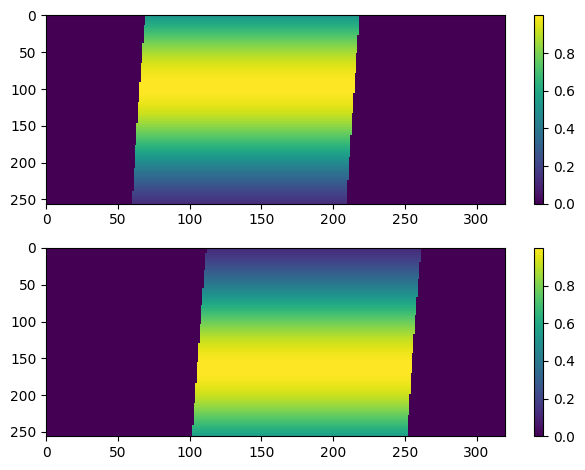

In [73]:
plt.figure()
k = 1
for i in [1,3]:

    R_eta = np.sqrt(NPosition[i, 0]**2 + Vr**2 * (t_etaY - Tar_t_eta_0[i])**2)
    A0 = np.array([1, 1, 1, 1]) * np.exp(1j * 0)
    wr = (np.abs(t_tauX - 2 * R_eta / c) <= Tr / 2)
    wa = np.sinc(0.886 * np.arctan(Vg * (t_etaY - Tar_t_eta_c[i]) / NPosition[i, 0]) / theta_bw)**2
    st_tt_tar = A0[i] * wr * wa * np.exp(-1j * 4 * np.pi * f0 * R_eta / c) * np.exp(1j * np.pi * Kr * (t_tauX - 2 * R_eta / c)**2)
    plt.subplot(2,1,k)
    plt.pcolormesh(np.abs(st_tt_tar))
    bottom,top = plt.ylim()
    plt.ylim(top,bottom)
    plt.colorbar()
    k+=1
plt.tight_layout()
plt.show()

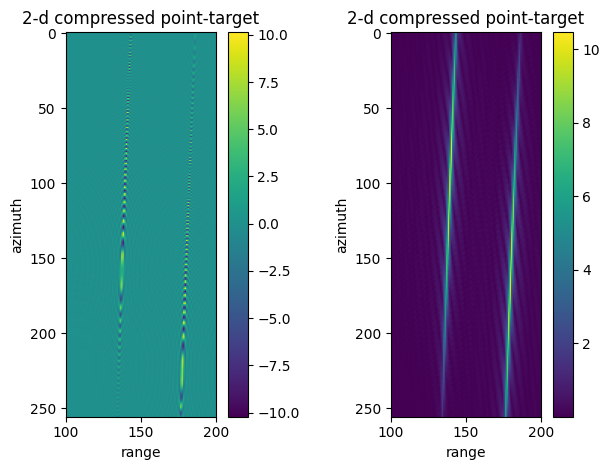

In [76]:

# 信号设置：一次距离压缩
window = ss.get_window(window=('kaiser',0),Nx=Nrg)  # 时域窗
Window = np.fft.fftshift(window)  # 频域窗
Hrf = (np.abs(f_tau_X) <= Bw/2) * Window * np.exp(1j * np.pi * f_tau_X**2 / Kr)
Sf_ft = np.fft.fft(st_tt, axis=1)
Srf_tf = Sf_ft * Hrf
srt_tt = np.fft.ifft(Srf_tf, axis=1)
# print(np.abs(S_mf))
plt.figure()
plt.subplot(1,2,1)
plt.imshow((np.real(srt_tt)))
plt.title('2-d compressed point-target')
plt.xlabel('range')
plt.ylabel('azimuth')
plt.colorbar()
plt.xlim(100,200)


plt.subplot(1,2,2)
plt.imshow((np.abs(srt_tt)))
plt.title('2-d compressed point-target')
plt.xlabel('range')
plt.ylabel('azimuth')
plt.colorbar()
plt.xlim(100,200)

plt.tight_layout()
plt.show()
# 信号设置：方位向傅里叶变换
Saf_tf = np.fft.fft(srt_tt, axis=0)


In [ ]:

# 信号设置：距离徙动校正
print('Vr:',Vr)
print('Reta:',R_eta_c,'R0:',R0)
print(rho_r)
# 距离徙动校正
RCM = lambda_r**2 * r_tauX * f_etaY**2 / (8 * Vr**2)  # 需要校正的距离徙动量
print('1:',RCM)
RCM = R0 + RCM - R_eta_c  # 将距离徙动量转换到原图像坐标系中
offset = RCM / rho_r  # 将距离徙动量转换为距离单元偏移量
print('2:',offset)
print(offset.max())

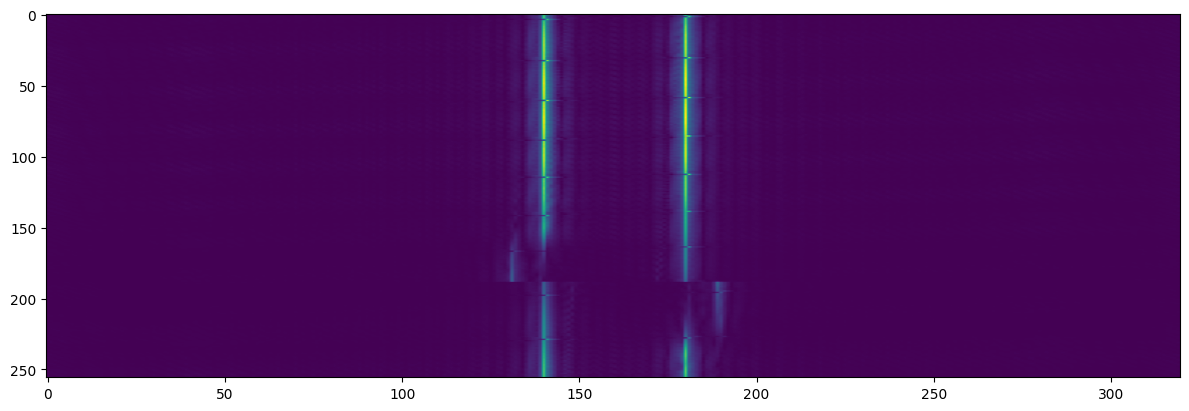

In [57]:

# 计算插值系数表
# x_tmp = np.repeat(np.arange(-4, 4), 16).reshape((16, 8))  # 插值长度
# x_tmp += np.repeat(np.arange(1, 17)[:, np.newaxis] / 16, 8, axis=1)  # 量化位移
# hx = np.sinc(x_tmp)  # 生成插值核
# kwin = np.repeat(np.kaiser(8, 2.5)[np.newaxis, :], 16, axis=0)  # 加窗
# hx *= kwin
# hx /= np.sum(hx, axis=1, keepdims=True)  # 核的归一化

interp_num = 8
interp_step = 16
# interp_pos = np.linspace(0,1-1/interp_step,interp_step)
interp_pos = np.linspace(1/interp_step,1,interp_step)
interp_ind = np.arange(-interp_num/2,interp_num/2,1)
interp_xvalue = interp_ind.reshape(1,interp_num) + interp_pos.reshape(interp_step,1)
hx = np.sinc(interp_xvalue)
kwin = ss.get_window(window=('kaiser',0),Nx=interp_num).reshape(1,8)
hx *= kwin
hx /= np.sum(hx, axis=1, keepdims=True) 
# print(kwin)
# print(interp_xvalue)
# print(hx)



# 插值表校正
Srcmf_tf = np.zeros_like(Saf_tf)
for a_tmp in range(Naz):
    for r_tmp in range(Nrg):
        offset_ceil = np.ceil(offset[a_tmp, r_tmp])
        offset_frac = np.round((offset_ceil - offset[a_tmp, r_tmp]) * 16).astype(int) - 1
        # print(offset_ceil,hx[offset_frac, :])
        if offset_frac == 0:
            Srcmf_tf[a_tmp, r_tmp] = Saf_tf[a_tmp, int((r_tmp + offset_ceil - 0.1) % Nrg)]
        else:
            # print(np.ceil((np.mod((np.arange(r_tmp + offset_ceil - 4, r_tmp + offset_ceil + 4) - 0.1), Nrg))))
            Srcmf_tf[a_tmp, r_tmp] = np.dot(
                Saf_tf[a_tmp, -1 + np.ceil((np.mod((np.arange(r_tmp + offset_ceil - 4, r_tmp + offset_ceil + 4) - 0.1), Nrg))).astype(int)],
                hx[offset_frac, :].T
            )

# 绘图
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.imshow(np.abs(Srcmf_tf), aspect='auto')


plt.tight_layout()
plt.show()


[[40.48556963 40.48039013 40.47521195 ... 38.90746627 38.90268266
  38.89790023]
 [40.48556963 40.48039013 40.47521195 ... 38.90746627 38.90268266
  38.89790023]
 [40.48556963 40.48039013 40.47521195 ... 38.90746627 38.90268266
  38.89790023]
 ...
 [40.48556963 40.48039013 40.47521195 ... 38.90746627 38.90268266
  38.89790023]
 [40.48556963 40.48039013 40.47521195 ... 38.90746627 38.90268266
  38.89790023]
 [40.48556963 40.48039013 40.47521195 ... 38.90746627 38.90268266
  38.89790023]]


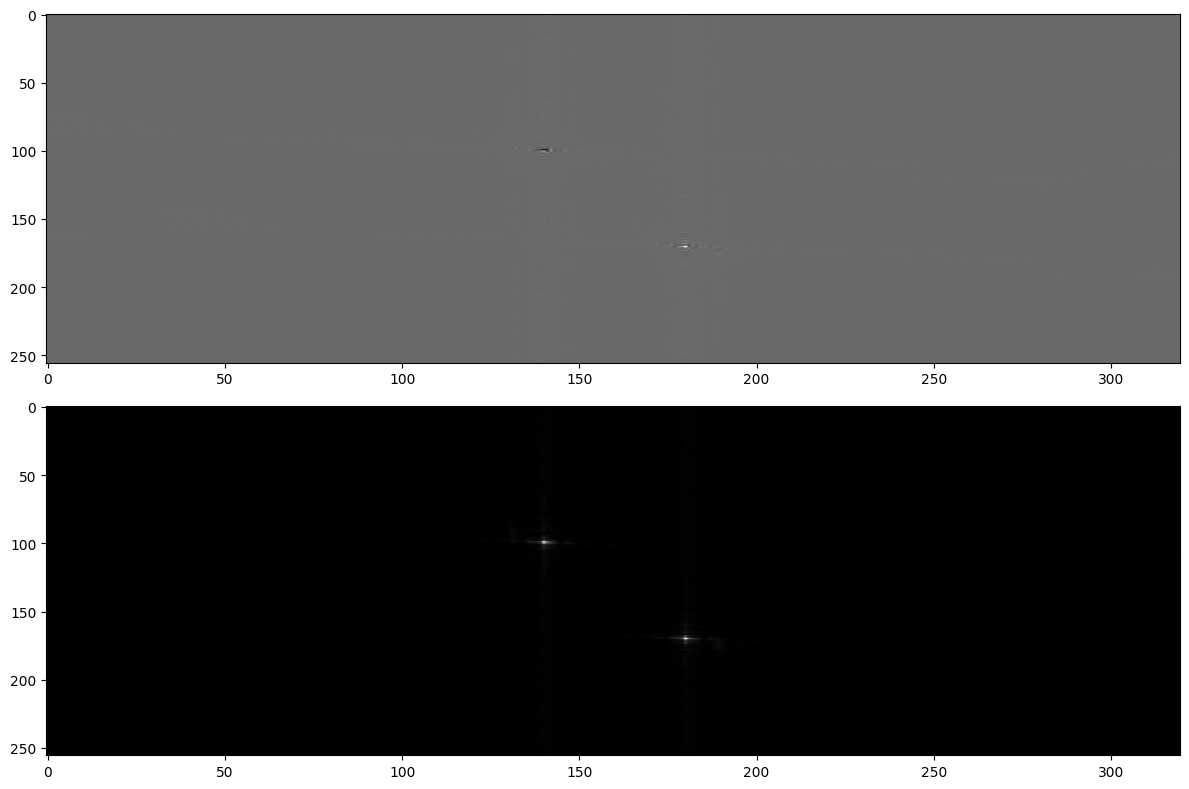

In [59]:

# 方位压缩
Ka = 2 * Vr**2 * np.cos(theta_r_c)**2 / (lambda_r * r_tauX)  # 方位向调频率
Haf = np.exp(-1j * np.pi * f_etaY**2 / Ka)
Haf_offset = np.exp(-1j * 2 * np.pi * f_etaY * t_eta_c)
Soutf_tf = Srcmf_tf * Haf * Haf_offset
soutt_tt = np.fft.ifft(Soutf_tf, axis=0)
print(Ka)
# 绘图
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.imshow(np.real(soutt_tt), aspect='auto', cmap='gray')


plt.subplot(212)
plt.imshow(np.abs(soutt_tt), aspect='auto', cmap='gray')

plt.tight_layout()
plt.show()
